## Portfolio Exercise: Starbucks
<br>

<img src="https://opj.ca/wp-content/uploads/2018/02/New-Starbucks-Logo-1200x969.jpg" width="200" height="200">
<br>
<br>
 
#### Background Information

The dataset you will be provided in this portfolio exercise was originally used as a take-home assignment provided by Starbucks for their job candidates. The data for this exercise consists of about 120,000 data points split in a 2:1 ratio among training and test files. In the experiment simulated by the data, an advertising promotion was tested to see if it would bring more customers to purchase a specific product priced at $10. Since it costs the company 0.15 to send out each promotion, it would be best to limit that promotion only to those that are most receptive to the promotion. Each data point includes one column indicating whether or not an individual was sent a promotion for the product, and one column indicating whether or not that individual eventually purchased that product. Each individual also has seven additional features associated with them, which are provided abstractly as V1-V7.

#### Optimization Strategy

Your task is to use the training data to understand what patterns in V1-V7 to indicate that a promotion should be provided to a user. Specifically, your goal is to maximize the following metrics:

* **Incremental Response Rate (IRR)** 

IRR depicts how many more customers purchased the product with the promotion, as compared to if they didn't receive the promotion. Mathematically, it's the ratio of the number of purchasers in the promotion group to the total number of customers in the purchasers group (_treatment_) minus the ratio of the number of purchasers in the non-promotional group to the total number of customers in the non-promotional group (_control_).

$$ IRR = \frac{purch_{treat}}{cust_{treat}} - \frac{purch_{ctrl}}{cust_{ctrl}} $$


* **Net Incremental Revenue (NIR)**

NIR depicts how much is made (or lost) by sending out the promotion. Mathematically, this is 10 times the total number of purchasers that received the promotion minus 0.15 times the number of promotions sent out, minus 10 times the number of purchasers who were not given the promotion.

$$ NIR = (10\cdot purch_{treat} - 0.15 \cdot cust_{treat}) - 10 \cdot purch_{ctrl}$$

For a full description of what Starbucks provides to candidates see the [instructions available here](https://drive.google.com/open?id=18klca9Sef1Rs6q8DW4l7o349r8B70qXM).

Below you can find the training data provided.  Explore the data and different optimization strategies.

#### How To Test Your Strategy?

When you feel like you have an optimization strategy, complete the `promotion_strategy` function to pass to the `test_results` function.  
From past data, we know there are four possible outomes:

Table of actual promotion vs. predicted promotion customers:  

<table>
<tr><th></th><th colspan = '2'>Actual</th></tr>
<tr><th>Predicted</th><th>Yes</th><th>No</th></tr>
<tr><th>Yes</th><td>I</td><td>II</td></tr>
<tr><th>No</th><td>III</td><td>IV</td></tr>
</table>

The metrics are only being compared for the individuals we predict should obtain the promotion – that is, quadrants I and II.  Since the first set of individuals that receive the promotion (in the training set) receive it randomly, we can expect that quadrants I and II will have approximately equivalent participants.  

Comparing quadrant I to II then gives an idea of how well your promotion strategy will work in the future. 

Get started by reading in the data below.  See how each variable or combination of variables along with a promotion influences the chance of purchasing.  When you feel like you have a strategy for who should receive a promotion, test your strategy against the test dataset used in the final `test_results` function.

### Data Understanding

We need to find the features lead to more purchases in the group that got the promotion compared to the control group.

But first we want to understand the provided data in more detail.

In [29]:
# load in packages
from itertools import combinations

from test_results import test_results, score
import numpy as np
import pandas as pd
import scipy as sp
import sklearn as sk

import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

sns.set()

# load in the data
train_data = pd.read_csv('data/training.csv')
train_data.head()

,ID,Promotion,purchase,V1,V2,V3,V4,V5,V6,V7
0,1,No,0,2,30.443518,-1.165083,1,1,3,2
1,3,No,0,3,32.159350,-0.645617,2,3,2,2
2,4,No,0,2,30.431659,0.133583,1,1,4,2
3,5,No,0,0,26.588914,-0.212728,2,1,4,2
4,8,Yes,0,3,28.044332,-0.385883,1,1,2,2


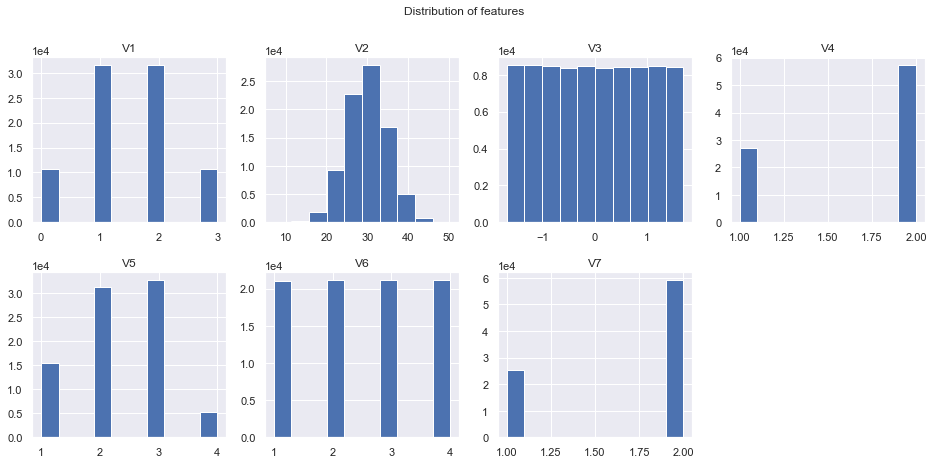

In [2]:
# We plot the distributions of all the features
features = train_data.columns[3:]

i = 1
plt.figure(figsize=(16, 7))
plt.subplots_adjust(hspace=.3)
for feature in features:
    plt.subplot(2, 4, i)
    plt.hist(train_data[feature])
    i+=1
    plt.title(feature)
    plt.ticklabel_format(axis='y', style='sci', scilimits=(0,0))
    
plt.suptitle('Distribution of features')
plt.show()

There are **only two continuous** features. The rest of the features seam to be categorical or ordinal.

In [21]:
continuous_features = ['V2', 'V3']
categorical_features = ['V1', 'V4', 'V5', 'V6', 'V7']

#### Encoding categorical variables

In [22]:
df = pd.get_dummies(train_data, columns=categorical_features)
df.drop('ID', axis=1, inplace=True)
df.head(5)

,Promotion,purchase,V2,V3,V1_0,V1_1,V1_2,V1_3,V4_1,V4_2,V5_1,V5_2,V5_3,V5_4,V6_1,V6_2,V6_3,V6_4,V7_1,V7_2
0,No,0,30.443518,-1.165083,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1
1,No,0,32.159350,-0.645617,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1
2,No,0,30.431659,0.133583,0,0,1,0,1,0,1,0,0,0,0,0,0,1,0,1
3,No,0,26.588914,-0.212728,1,0,0,0,0,1,1,0,0,0,0,0,0,1,0,1
4,Yes,0,28.044332,-0.385883,0,0,0,1,1,0,1,0,0,0,0,1,0,0,0,1


#### Comparing experiment and control group

In [65]:
def check_split(data, feature, split=.5):
    ''' Check if the features distribution can be result from random sampling '''
    
    group_exp = data[data['Promotion'] == 'Yes'][feature]
    group_control = data[data['Promotion'] == 'No'][feature]

    p_null = split
    n_total = sum(group_exp) + sum(group_control)

    mu = p_null * n_total

    std = np.sqrt(p_null * (1-p_null) * n_total)
    n_control = sum(group_control)

    z_score = ((n_control + .5) - n_total * p_null) / std

    p_value = 2 * sp.stats.norm.cdf(z_score)
    if p_value <= .05:
        print('** Feature {} has p-value of {} and null hypothesis needs to be rejected'.format(feature, p_value))
    else:
        print('Feature {} is balanced (p_value={:.3})'.format(feature, p_value))

In [66]:
categorical_features = ['V1_0', 'V1_1', 'V1_2', 'V1_3', 'V4_1', 'V4_2', 'V5_1', 'V5_2', 'V5_3', 'V5_4', 'V6_1', 
                        'V6_2', 'V6_3', 'V6_4', 'V7_1', 'V7_2']
for feature in categorical_features:
    check_split(df, feature)

Feature V1_0 is balanced (p_value=1.44)
Feature V1_1 is balanced (p_value=1.21)
Feature V1_2 is balanced (p_value=0.283)
Feature V1_3 is balanced (p_value=0.3)
Feature V4_1 is balanced (p_value=0.477)
Feature V4_2 is balanced (p_value=0.754)
Feature V5_1 is balanced (p_value=0.256)
Feature V5_2 is balanced (p_value=1.09)
Feature V5_3 is balanced (p_value=0.304)
Feature V5_4 is balanced (p_value=1.9)
Feature V6_1 is balanced (p_value=0.951)
Feature V6_2 is balanced (p_value=0.767)
Feature V6_3 is balanced (p_value=0.685)
Feature V6_4 is balanced (p_value=0.587)
Feature V7_1 is balanced (p_value=0.529)
Feature V7_2 is balanced (p_value=0.706)


All features are balanced between the experimental and the control group. We know need to search for differences of the promotion parts of the different grooups.

#### Search for statistically relevant differences

In [202]:
def calculate_irr(data):
    ''' Calculates the incremental response rate '''
    
    experiment_group = data[data['Promotion'] == 'Yes']
    control_group = data[data['Promotion'] == 'No']
    
    return experiment_group['purchase'].sum()/len(experiment_group) - control_group['purchase'].sum()/len(control_group)

In [203]:
def calculate_nir(data):
    ''' Calculates the net incremental revenue '''
    
    experiment_group = data[data['Promotion'] == 'Yes']
    control_group = data[data['Promotion'] == 'No']
    
    return (10 * experiment_group['purchase'].sum() - .15 * len(experiment_group)) - 10 * control_group['purchase'].sum()

In [265]:
def check_purchases_for_feature(data, feature):
    ''' 
    Calculated probability of the differences in amout of purchases 
    between the group that have this features and the group which do not 
    '''
    
    # Observed proportion of purchases for feature
    p_null = data.purchase.mean()

    # Calculate counts of different groups
    n_total = sum(data[feature])
    data_control = data[data['Promotion'] == 'No']
    data_experiment = data[data['Promotion'] == 'Yes']
    n_control = sum(data_control[feature])
    n_experiment = sum(data_experiment[feature])

    # Calculate means of purchases between experiment and control group
    mean_control, mean_experiment = data[data[feature] == 1].groupby('Promotion')['purchase'].mean().values

    # Calculate standard error
    std_error = np.sqrt(p_null * (1-p_null) * (1/n_control + 1/n_experiment))

    # Calculate z-score of actual difference
    z_score = (mean_experiment - mean_control) / std_error

    # Caculate probability of result
    p_value = 1 - sp.stats.norm.cdf(z_score)

    if p_value < .01:
        significance = '***'
    elif p_value < .05:
        significance = '**'
    elif p_value < .1:
        significance = '*'
    else:
        significance = ''
    purchase_delta = data_experiment[data_experiment[feature] == 1]['purchase'].sum() \
                                      - data_control[data_control[feature] == 1]['purchase'].sum()
    
    irr = calculate_irr(data[data[feature] == 1])
    nir = calculate_nir(data[data[feature] == 1])
    print('{:<6} {:>6}: {:<10.4} (p-value)'.format(significance, feature, p_value))
    print('         Diff. in Purchases: {:<5} IRR: {:<10.4} NIR :{:0.2f}'.format(purchase_delta,
                                                              irr, nir))
    return [feature, p_value, purchase_delta, irr, nir]

In [266]:
results = []
for feature in categorical_features:
    results.append(check_purchases_for_feature(df, feature))

***      V1_0: 1.158e-07  (p-value)
         Diff. in Purchases: 58    IRR: 0.01106    NIR :-212.45
***      V1_1: 2.542e-09  (p-value)
         Diff. in Purchases: 114   IRR: 0.007245   NIR :-1228.80
***      V1_2: 0.0        (p-value)
         Diff. in Purchases: 199   IRR: 0.01244    NIR :-395.00
***      V1_3: 0.004301   (p-value)
         Diff. in Purchases: 31    IRR: 0.005608   NIR :-498.35
         V4_1: 0.5838     (p-value)
         Diff. in Purchases: -3    IRR: -0.0002836 NIR :-2070.15
***      V4_2: 0.0        (p-value)
         Diff. in Purchases: 405   IRR: 0.01406    NIR :-264.45
***      V5_1: 2.52e-14   (p-value)
         Diff. in Purchases: 105   IRR: 0.01337    NIR :-116.55
**       V5_2: 0.02214    (p-value)
         Diff. in Purchases: 39    IRR: 0.002511   NIR :-1948.35
***      V5_3: 0.0        (p-value)
         Diff. in Purchases: 237   IRR: 0.01431    NIR :-99.75
***      V5_4: 0.002315   (p-value)
         Diff. in Purchases: 21    IRR: 0.008674   NIR :-169.9

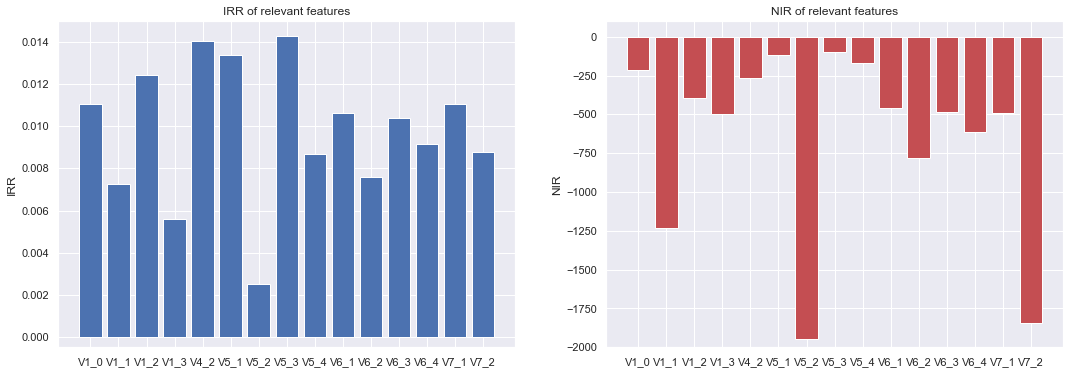

In [376]:
alpha = .05

significant_features = list(filter(lambda x: x[1] < alpha, results))

plt.figure(figsize=(18, 6))
plt.subplot(1,2,1)
plt.bar([f[0] for f in significant_features], [irr for f, p, d, irr, nir in significant_features])
plt.title('IRR of relevant features')
plt.ylabel('IRR')
plt.ylim([-.0005, 0.015])
plt.subplot(1,2,2)
plt.bar([f[0] for f in significant_features], [nir for f, p, d, irr, nir in significant_features],
       color='r')
plt.title('NIR of relevant features')
plt.ylim([-2000, 100])
plt.ylabel('NIR')
plt.show()

The IRR of the features are clear and show that the promotion did increase the purchases. Unfortunately the net incremental revenue for every feature alone is not alone and therefore the model has to incorporate different features.

### Modelling

#### Build baseline model

We start the modelling part by building a baseline model that randomly picks participiants for the experimental group.

In [370]:
test_results(lambda df: np.random.choice(['Yes', 'No'], len(df)))

Nice job!  See how well your strategy worked on our test data below!

Your irr with this strategy is 0.0096.

Your nir with this strategy is -576.05.
We came up with a model with an irr of 0.0188 and an nir of 189.45 on the test set.

 How did you do?


(0.009575048106082115, -576.05)

#### Build more sophisticated model based on IRR and NIR

Based on the calculations of the IRR we select the features with the highest gain for our model.

In [383]:
def promotion_strategy(df):
    '''
    INPUT 
    df - a dataframe with *only* the columns V1 - V7 (same as train_data)

    OUTPUT
    promotion_df - np.array with the values
                   'Yes' or 'No' related to whether or not an 
                   individual should recieve a promotion 
                   should be the length of df.shape[0]
                
    Ex:
    INPUT: df
    
    V1	V2	  V3	V4	V5	V6	V7
    2	30	-1.1	1	1	3	2
    3	32	-0.6	2	3	2	2
    2	30	0.13	1	1	4	2
    
    OUTPUT: promotion
    
    array(['Yes', 'Yes', 'No'])
    indicating the first two users would recieve the promotion and 
    the last should not.
    '''
    
    
    
    return promotion

### Evaluation

In [ ]:
# This will test your results, and provide you back some information 
# on how well your promotion_strategy will work in practice

test_results(promotion_strategy)

In [391]:
data.head(2)

,Promotion,purchase,V2,V3,V1_0,V1_1,V1_2,V1_3,V4_1,V4_2,V5_1,V5_2,V5_3,V5_4,V6_1,V6_2,V6_3,V6_4,V7_1,V7_2
0,No,0,30.443518,-1.165083,0,0,1,0,1,0,1,0,0,0,0,0,1,0,0,1
1,No,0,32.159350,-0.645617,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1


In [398]:
data.iloc[:, 4:].apply(lambda row: 'Yes' if (row['V1_0'] == 1 or row['V1_2'] == 1) else 'No', axis=1)

0        Yes
1         No
2        Yes
3        Yes
4         No
5         No
6         No
7        Yes
8        Yes
9         No
10        No
11       Yes
12        No
13       Yes
14        No
15       Yes
16        No
17        No
18        No
19       Yes
20        No
21       Yes
22       Yes
23        No
24        No
25        No
26        No
27        No
28        No
29       Yes
        ... 
84504     No
84505     No
84506    Yes
84507    Yes
84508    Yes
84509     No
84510     No
84511    Yes
84512     No
84513     No
84514     No
84515    Yes
84516    Yes
84517     No
84518     No
84519     No
84520     No
84521     No
84522     No
84523     No
84524    Yes
84525    Yes
84526     No
84527     No
84528    Yes
84529     No
84530     No
84531     No
84532     No
84533     No
Length: 84534, dtype: object